# Time Series Null Model
#### *use the `sktime` conda environment*

### Contents:
 - [Import for Time Series Models](#Import-for-Time-Series-Models)
 - [Set X and y and TTS](#Set-X-and-y-and-TTS)
 - [Plot Data and Null Model](#Plot-Data-and-Null-Model)
 - [Null Model (Mean value)](#Null-Model-(Mean-value))
 - [Seasonal Model by Months](#Seasonal-Model-by-Months)


## Import for Time Series Models
[(back to top)](#Time-Series-Null-Model)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [2]:
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing
import statsmodels
import sktime

import pmdarima as pmd
from pmdarima.utils import tsdisplay

In [3]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.datasets import load_airline
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting import plot_series
from sktime.forecasting.compose import EnsembleForecaster

import pickle

In [4]:
df = pd.read_csv('../data/elec_mo_2001_2011_consumption.csv')

In [5]:
df.columns

Index(['date', 'STATE', 'CONSUMPTION'], dtype='object')

In [6]:
df['date'] = pd.to_datetime(df['date'])

In [7]:
df.set_index('date', inplace=True)

In [8]:
df.shape

(6864, 2)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6864 entries, 2001-01-01 to 2011-12-01
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   STATE        6864 non-null   object 
 1   CONSUMPTION  6864 non-null   float64
dtypes: float64(1), object(1)
memory usage: 160.9+ KB


In [10]:
df_nc = df[df['STATE'] == 'NC']

In [11]:
df_nc.index = df_nc.index.to_period('M')
df_nc.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 132 entries, 2001-01 to 2011-12
Freq: M
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   STATE        132 non-null    object 
 1   CONSUMPTION  132 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.1+ KB


## Set X and y and TTS
[(back to top)](#Time-Series-Null-Model)

In [12]:
X = df_nc.drop(columns=['CONSUMPTION'])
y = df_nc['CONSUMPTION']

In [13]:
X_train = X[X.index.year < 2010]
X_test = X[X.index.year >= 2010]
y_train = y[y.index.year < 2010]
y_test = y[y.index.year >= 2010]

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(108, 1)
(24, 1)
(108,)
(24,)


In [15]:
24/(108+24)

0.18181818181818182

## Plot Data and Null Model
[(back to top)](#Time-Series-Null-Model)

In [16]:
X = df_nc.drop(columns=['CONSUMPTION'])
y = df_nc['CONSUMPTION']

In [17]:
X_train = X[X.index.year < 2010]
X_test = X[X.index.year >= 2010]
y_train = y[y.index.year < 2010]
y_test = y[y.index.year >= 2010]

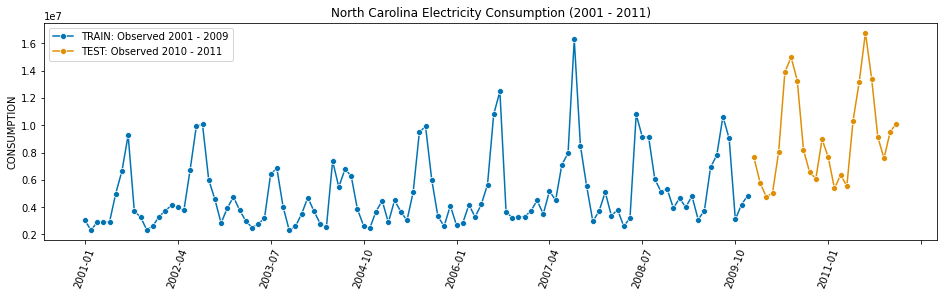

In [18]:
plot_series(y_train, y_test, labels=['TRAIN: Observed 2001 - 2009', 'TEST: Observed 2010 - 2011'])
plt.xticks(rotation=70)
plt.title('North Carolina Electricity Consumption (2001 - 2011)');

## Null Model (Mean value)
[(back to top)](#Time-Series-Null-Model)

In [19]:
y_train.resample('M')
y_train

date
2001-01     3049116.0
2001-02     2312318.0
2001-03     2906287.0
2001-04     2891829.0
2001-05     2927038.0
              ...    
2009-08    10629810.0
2009-09     9045856.0
2009-10     3098768.0
2009-11     4185647.0
2009-12     4851456.0
Freq: M, Name: CONSUMPTION, Length: 108, dtype: float64

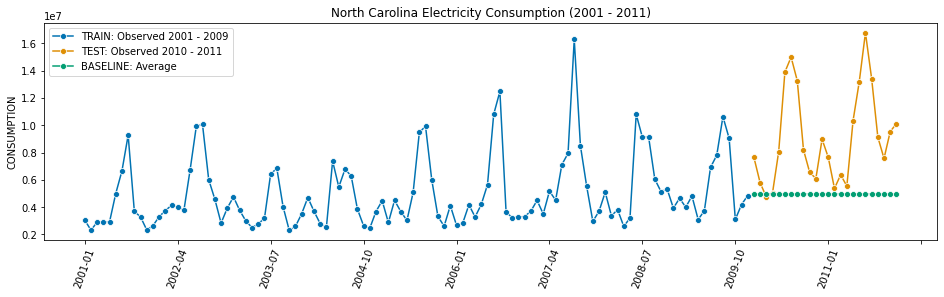

In [20]:
null_model = NaiveForecaster(strategy='mean')
null_model.fit(y_train)
null_line = null_model.predict(list(range(1, 25)))
plot_series(y_train, y_test, null_line, labels=['TRAIN: Observed 2001 - 2009', 'TEST: Observed 2010 - 2011', 'BASELINE: Average'])
plt.xticks(rotation=70)
plt.title('North Carolina Electricity Consumption (2001 - 2011)');
# plt.savefig('../images/electric_time_series_null_model', bbox_inches='tight')

In [21]:
print(f'MSE: {round(mse(y_test, null_line, squared=False), 0)}')
print(f'MAE: {round(mae(y_test, null_line), 0)}')

MSE: 5359973.0
MAE: 4164017.0


## Seasonal Model by Months
[(back to top)](#Time-Series-Null-Model)

In [22]:
num_months = list(range(1, len(y_test) + 1))

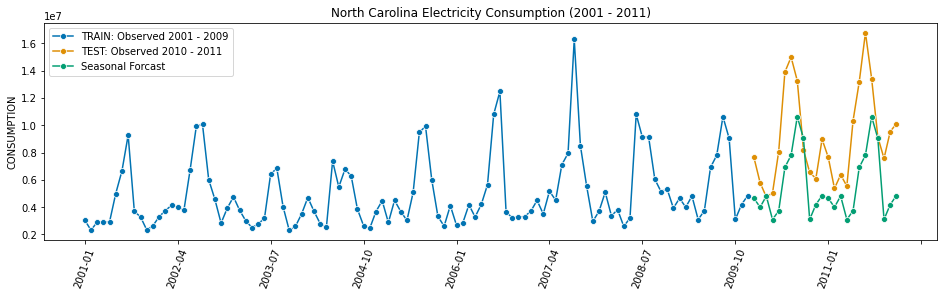

In [23]:
# Seasonal
naive_seasonal = NaiveForecaster(strategy='last', sp=12)
naive_seasonal.fit(y_train)
naive_seasonal_preds = naive_seasonal.predict(num_months)
plot_series(y_train, y_test, naive_seasonal_preds, labels=['TRAIN: Observed 2001 - 2009', 'TEST: Observed 2010 - 2011', 'Seasonal Forcast'])
plt.xticks(rotation=70)
plt.title('North Carolina Electricity Consumption (2001 - 2011)');
# plt.savefig('../images/electric_time_series_seasonal_forecast', bbox_inches='tight')

In [24]:
round(mse(y_test, naive_seasonal_preds, squared=False), 0)

4294624.0